In [1]:
import sys
import numpy as np
from scipy import linalg
from scipy.spatial import distance
import matplotlib.pyplot as plt

In [2]:
np.random.seed(1)
s0 = np.loadtxt('s0_PF00186.txt').astype(int)

In [3]:
q = 21
theta=0.2
pseudo_weight=0.5

l,n = s0.shape
mx = np.full(n,q)

In [4]:
s0.shape

(6734, 133)

In [5]:
# hamming distance
dst = distance.squareform(distance.pdist(s0, 'hamming'))
W = 1./(1+(dst < theta).sum(axis=1).astype(float))
np.savetxt('ma.dat',W,fmt='% f')
Meff = W.sum()

In [6]:
print(Meff)

2588.7662702035


In [7]:
# Pi_true, Pij_true:
Pi_true = np.zeros((n,q))
for t in range(l):
    for i in range(n):
        Pi_true[i,s0[t,i]] = Pi_true[i,s0[t,i]] + W[t]

Pi_true = Pi_true/Meff    

In [8]:
np.savetxt('Pi_true.dat',Pi_true,fmt='% f')

In [9]:
Pi_sum = Pi_true.sum(axis=1)
print(Pi_sum)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [10]:
Pij_true = np.zeros((n,n,q,q))
for t in range(l):
    for i in range(n-1):
        for j in range(i+1,n):
            Pij_true[i,j,s0[t,i],s0[t,j]] = Pij_true[i,j,s0[t,i],s0[t,j]] + W[t]
            Pij_true[j,i,s0[t,j],s0[t,i]] = Pij_true[i,j,s0[t,i],s0[t,j]]

Pij_true = Pij_true/Meff  

In [11]:
scra = np.eye(q)
for i in range(n):
    for alpha in range(q):
        for beta in range(q):
            Pij_true[i,i,alpha,beta] = Pi_true[i,alpha]*scra[alpha,beta]            

In [12]:
# Pi, Pij
Pi = (1 - pseudo_weight)*Pi_true + pseudo_weight/q
Pij = (1 - pseudo_weight)*Pij_true + pseudo_weight/(q**2)

In [13]:
scra = np.eye(q)
for i in range(n):
    for alpha in range(q):
        for beta in range(q):
            Pij[i,i,alpha,beta] = (1 - pseudo_weight)*Pij_true[i,i,alpha,beta]\
                                    + pseudo_weight/q*scra[alpha,beta]

In [14]:
# compute correlation matrix:
def mapkey(i,alpha,q):
    #return (q-1)*(i-1) + alpha
    return i*(q-1) + alpha

C = np.zeros((n*(q-1),n*(q-1)))
for i in range(n):
    for j in range(n):
        for alpha in range(q-1):
            for beta in range(q-1):
                C[mapkey(i,alpha,q),mapkey(j,beta,q)] = Pij[i,j,alpha,beta] - Pi[i,alpha]*Pi[j,beta]

In [15]:
C_inv = linalg.inv(C)

In [16]:
C_inv.shape

(2660, 2660)

In [17]:
np.savetxt('C_inv.dat',C_inv,fmt='% f')

In [48]:
# set w = - C_inv
def ReturnW(C_inv,i,j,q):
    w = np.zeros((q,q))    
    for alpha in range(q-1):
        for beta in range(q-1):
            w[alpha,beta] = -C_inv[mapkey(i,alpha,q),mapkey(j,beta,q)]    
    return w

#---------------------------------------------------------------------------------

di = np.zeros((n,n))
tiny = 10**(-100.)
diff_thres = 10**(-4.)

f = open('ew.dat','w')
eh1eh2_out = open('eh1eh2.dat','w')
di_out = open('di.dat','w')
for i in range(n-1):
    for j in range(i+1,n):
        
        # ew:
        w_mf = ReturnW(C_inv,i,j,q)
        ew = np.exp(w_mf)
        
        # print
        for iq in range(q):
            for jq in range(q):
                f.write("% i % i % i % i % f \n" % (i+1,j+1,iq,jq,ew[iq,jq]))
                        
        #------------------------------------------------------
        # find h1 and h2:
        
        # initial value
        diff = diff_thres + 1.
        eh1 = np.full(q,1./q)
        eh2 = np.full(q,1./q)
        
        fi0 = Pi[i,:]
        fj0 = Pi[j,:]
        
        for iloop in range(100):
            eh_ew1 = eh2.dot(ew.T)
            eh_ew2 = eh1.dot(ew)

            eh1_new = fi0/eh_ew1
            eh1_new /= eh1_new.sum()

            eh2_new = fj0/eh_ew2
            eh2_new /= eh2_new.sum()

            diff = max(np.max(np.abs(eh1_new - eh1)),np.max(np.abs(eh2_new - eh2)))

            eh1,eh2 = eh1_new,eh2_new    
            if diff < diff_thres: break        

        # print eh1,eh2
        for iq in range(q):
            eh1eh2_out.write("% i % i % i % f % f \n" % (i+1,j+1,iq+1,eh1[iq],eh2[iq]))
                                
        # direct information
        eh1eh2 = eh1[:,np.newaxis]*eh2[np.newaxis,:]
        pdir = ew*(eh1eh2)
        pdir /= pdir.sum() 
        
        fifj = fi0[:,np.newaxis]*fj0[np.newaxis,:]
        
        dijab = pdir*np.log(pdir/fifj)        
        di[i,j] = dijab.sum()
        
        di_out.write("% i % i % f \n" % (i+1,j+1,di[i,j]))
                
f.close()
eh1eh2_out.close()
di_out.close()

In [49]:
di = di + di.T

In [50]:
np.savetxt('di.dat',di,fmt='% f')

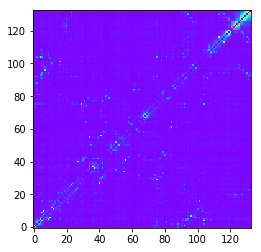

In [51]:
plt.imshow(di,cmap='rainbow',origin='lower')